In [1]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [2]:
import zen
import matplotlib.pyplot as plt
import numpy as np

In [111]:
def katz(G,tol=0.01,max_iter=1000,alpha=0.001,beta=1):
    iteration = 0
    centrality = np.zeros(G.num_nodes)
    while iteration < max_iter:
        iteration += 1          # increment iteration count
        centrality_old = centrality.copy()

        for node in G.nodes_():
            Ax = 0
            for neighbor in G.neighbors_(node):
                weight = G.weight_(G.edge_idx_(neighbor,node))
                Ax += np.multiply(centrality[neighbor],weight)

                #Ax += centrality[neighbor]      #exclude weight due to overflow in multiplication

            centrality[node] = np.multiply(alpha,Ax)+beta

        if np.sum(np.abs(np.subtract(centrality,centrality_old))) < tol:
            return centrality

"[The DBLP computer science bibliography](https://snap.stanford.edu/data/com-DBLP.html) provides a comprehensive list of research papers in computer science. We construct a co-authorship network where two authors are connected if they publish at least one paper together."

In [4]:
import pandas as pd
dblp_df = pd.DataFrame(columns=['Node','Community'])

idx=0
comm=0
for line in log_progress(open('com-dblp.top5000.cmty.txt'),every=1,size=5000):
    nodes = line.split('\t')
    for node in nodes:
        dblp_df.loc[idx] = [int(node), comm]
        idx+=1
    comm+=1

VBox(children=(HTML(value=u''), IntProgress(value=0, max=5000)))

,Node,Community
0,105653,0
1,105654,0
2,210737,0
3,210738,0
4,210739,0


In [5]:
TwoLargestCom = dblp_df.groupby('Community').count().sort_values('Node',ascending=False).iloc[:2].index.values

sampled_nodes=dblp_df[(dblp_df['Community']==TwoLargestCom[0])|\
                      (dblp_df['Community']==TwoLargestCom[1])].set_index('Node')

In [108]:
#########################
# Only run this cell if the gml file is not available. Otherwise, run the next one to load the graph
#########################
G = zen.Graph()
for line in log_progress(open('com-dblp.ungraph.txt'),every=1,size=1049851):
    info = line.split('\t')
    n1 = int(info[0])
    n2 = int(info[1])
    
    node1_in = True
    try:
        _ = sampled_nodes.loc[n1,:]
    except KeyError:
        # not in comm
        node1_in = False
        
    node2_in = True
    try:
        _ = sampled_nodes.loc[n2,:]
    except KeyError:
        # not in comm
        node2_in = False
    
    if node1_in and node2_in:
        if not G.has_edge(n1,n2):
            G.add_edge(n1,n2)
        else:
            G.set_weight(n1,n2,G.weight(n1,n2)+1)
zen.io.gml.write(G,'dblp_top_2_weighted.gml')

VBox(children=(HTML(value=u''), IntProgress(value=0, max=1049724)))

In [176]:
#G = zen.io.gml.read('dblp_top_2.gml')
G = zen.io.gml.read('dblp_top_2_weighted.gml')

In [178]:
communities = sampled_nodes.groupby('Community').apply(lambda x: x.iloc[:,0])
comm_names = communities.index.get_level_values(0).unique()

C = {}
for name in comm_names:
    C[name] = communities.loc[name].index.values

Community  Node
4753       1991    4753
           2697    4753
           3406    4753
           3466    4753
           3558    4753
Name: Community, dtype: object

In [180]:
Q = zen.algorithms.modularity(G,C)

# Maximum Modularity
count=0.0
for e in log_progress(G.edges(),every=200):
    c1 = sampled_nodes.loc[e[0],'Community']
    c2 = sampled_nodes.loc[e[1],'Community']
    # if node is in both communities cx will be a Series type
    if type(c1) == pd.core.series.Series or type(c2) == pd.core.series.Series:
        count += 0
    elif c1 == c2:
        count += 1
same = count / G.num_edges
rand = same - Q
qmax = 1 - rand

print 'Modularity:      %.3f'%Q
print 'Max. Modularity: %.3f'%qmax
print 'Normalized Mod:  %.3f'%(Q/qmax)

VBox(children=(HTML(value=u''), IntProgress(value=0, max=34281)))

Modularity:      0.438
Max. Modularity: 0.529
Normalized Mod:  0.827


In [114]:
evc = zen.algorithms.eigenvector_centrality_(G,weighted=True)
#evc = evc - np.min(evc)
#evc = evc / np.max(evc)
kc = katz(G,alpha=1e-4)
#kc = kc - np.min(kc)
#kc = kc / np.max(kc)
cc = zen.algorithms.clustering.lcc_(G)

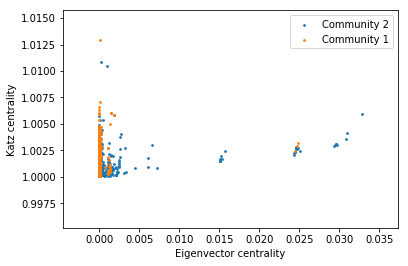

In [115]:
comms = communities.index.get_level_values(0).unique()
# comm 1
c1nodes = communities.loc[comms[0],:].index.get_level_values(1).values
c1nodeIdx = np.zeros(len(c1nodes),dtype=np.int64)
for i,x in enumerate(c1nodes):
    idx = G.node_idx(x)
    c1nodeIdx[i] = idx
    
# comm 2
c2nodes = communities.loc[comms[1],:].index.get_level_values(1).values
c2nodeIdx = np.zeros(len(c2nodes),dtype=np.int64)
for i,x in enumerate(c2nodes):
    idx = G.node_idx(x)
    c2nodeIdx[i] = idx
    
plt.scatter(evc[c2nodeIdx],kc[c2nodeIdx],s=3,label='Community 2')
plt.scatter(evc[c1nodeIdx],kc[c1nodeIdx],s=3,label='Community 1')
#plt.gca().set_xscale('log')
#plt.gca().set_yscale('log')
#plt.gca().set_xlim([1e-6,1])
#plt.gca().set_ylim([1e-6,1])
plt.legend()
plt.xlabel('Eigenvector centrality')
plt.ylabel('Katz centrality')
plt.show()

The graph more closely results from the first synthetic graph, with a distinction. Ine the first results, the denser of the two communities corresponded to the cluster with the smaller linear slope. However, Community 1 has a slightly larger average local clustering coefficient than Community 2, yet has a steeper linear slope.

In [11]:
avgCC1 = np.mean(cc[c1nodeIdx])
avgCC2 = np.mean(cc[c2nodeIdx])

print 'Community 1 average lcc: %.3f'%avgCC1
print 'Community 2 average lcc: %.3f'%avgCC2

Community 1 average lcc: 0.638
Community 2 average lcc: 0.576


There is much more of a distinction between the two communities in the centralities plot than seen in the EU-core network. The graph more closely results from the first synthetic graph. That the DBLP graph is strongly assortively mixed support the claim that distinct clusters in the Katz vs Eigenvector centrality plot only appear with strong assortative mixing. However, there are several nodes that appear in regions dominated by the opposite community. This might be explained by one or more of the following details about the network:

1. There are several nodes that are members of both communities. "Publication venue, e.g, journal or conference, defines an individual ground-truth community; authors who published to a certain journal or conference form a community." Authors frequently publish in numerous journals and conferences, causing community membership not to be disjoint.

2. Venue is not the only basis for ground-truth communities in the network. "We regard each connected component in a group as a separate ground-truth community." One of the communities sampled here may not be a publication venue community, but a connected component, hence the overlap in membership.

3. The different communities suggested by the centralities plot are different from the communities defined by publication venue/connected component.

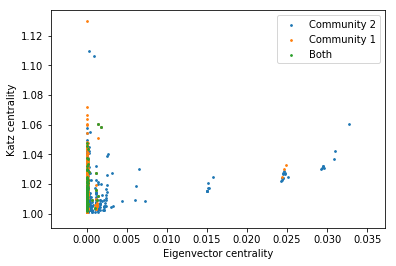

In [12]:
countedCom = sampled_nodes.groupby('Node').count()
doubled_nodes = countedCom.where(countedCom > 1).dropna().index.values

doubled_node_idx = [G.node_idx(node) for node in doubled_nodes]

plt.scatter(evc[c2nodeIdx],kc[c2nodeIdx],s=3,label='Community 2')
plt.scatter(evc[c1nodeIdx],kc[c1nodeIdx],s=3,label='Community 1')
plt.scatter(evc[doubled_node_idx],kc[doubled_node_idx],s=3,label='Both')
#plt.gca().set_xscale('log')
#plt.gca().set_yscale('log')
#plt.gca().set_xlim([1e-12,1])
#plt.gca().set_ylim([1e-9,1])
plt.legend()
plt.xlabel('Eigenvector centrality')
plt.ylabel('Katz centrality')
plt.show()

The "out of place" nodes are **not** the nodes in both communities. Thus, it seems that the third explaination is more likely.

In [161]:
evc_ = (evc-np.min(evc))/np.max(evc-np.min(evc))
kc_ = (kc - np.min(kc))/np.max(kc-np.min(kc))
X = np.array([evc_,kc_]).T
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(1e-4,10))
#X_ = scaler.fit_transform(X)
from sklearn.cluster import AgglomerativeClustering as AC

cluster = AC(n_clusters=2,affinity='cosine',linkage='average').fit(X) # update sklearn and try linkage='single'
labels = cluster.labels_

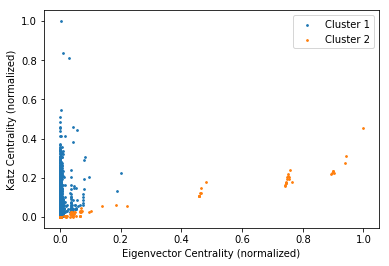

In [165]:
for x in [0,1]:
    idx = np.where(labels==x)[0]
    plt.scatter(evc_[idx],kc_[idx],s=3,label='Cluster %d'%(x+1))
plt.legend()
#plt.gca().set_xscale('log')
#plt.gca().set_yscale('log')
#plt.gca().set_xlim([1e-20,1])
#plt.gca().set_ylim([1e-20,1])
plt.xlabel('Eigenvector Centrality (normalized)')
plt.ylabel('Katz Centrality (normalized)')
plt.show()

In [182]:
C = {}
for x in [0,1]:
    C[x] = [G.node_object(i) for i in np.where(labels==x)[0]]

Q = zen.algorithms.modularity(G,C)

# Maximum Modularity
count=0.0
for e in G.edges():
    n1 = G.node_idx(e[0])
    n2 = G.node_idx(e[1])
    if labels[n1] == labels[n2]:
        count += 1
same = count / G.num_edges
rand = same - Q
qmax = 1 - rand

print 'Modularity:      %.3f'%Q
print 'Max. Modularity: %.3f'%qmax
print 'Normalized Mod:  %.3f'%(Q/qmax)

Modularity:      0.022
Max. Modularity: 0.039
Normalized Mod:  0.565


In [183]:
for x in C:
    print len(C[x])

12793
533
